## LSTM Auto-Encoder-Decoder for Anomaly Detection: 

## Detect anomalous points on time series data of cpu utilization

In [1]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(23)

### Read Data for Cpu utilization, we want to reconstruct the time series using LSTM based Auto-Encoder

In [3]:
df = pd.read_csv('df_merged.csv', parse_dates=['days'], index_col='days')

In [4]:
df.sample(5)

,dt,cur_time_in_gmt,cpu_utilization_pctg,hour,cpu_utilization_pctg_extrapolated,is_extrapolated
days,,,,,,
2017-07-21 01:00:00,7/20/2017,7/21/2017 1:00,50.833,1,50.833,False
2017-04-06 21:00:00,4/6/2017,4/6/2017 21:00,48.611,21,48.611,False
2017-05-12 21:00:00,5/12/2017,5/12/2017 21:00,58.889,21,58.889,False
2017-04-17 07:00:00,4/17/2017,4/17/2017 7:00,26.382,7,26.382,False
2017-04-04 07:00:00,4/4/2017,4/4/2017 7:00,34.167,7,34.167,False


**We collect cpu usage data per hour eveyday, so there are 24 readings per day**

In [5]:
df = df[['cpu_utilization_pctg_extrapolated']]
df.columns = ['cpu_util_pctg']
df.sample(5)

,cpu_util_pctg
days,
2017-04-15 03:00:00,61.066
2017-06-10 20:00:00,46.125
2017-07-06 03:00:00,55.833
2017-05-26 08:00:00,31.389
2017-05-02 23:00:00,33.629


In [6]:
from sklearn.preprocessing import StandardScaler

# Normalize the  data (center around 0 and scale to remove the variance).
scaler = StandardScaler()
df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

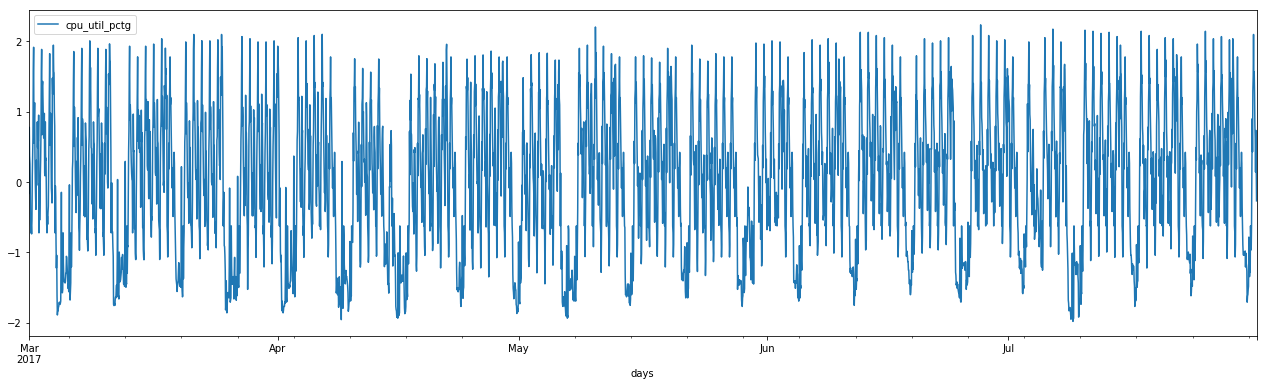

In [7]:
df.plot(figsize=(22,6));

In [8]:
len(df)

3672

In [9]:
df['cpu_util_pctg'] = df['cpu_util_pctg'] / 100

### Create the training, validation and test sets

In [10]:
signal_train = df['2017-03-01':'2017-05-31'].values # March to May
signal_valid = df['2017-06-01':'2017-06-30'].values # June
signal_test = df['2017-07-01':'2017-07-31'].values # July

**Prepare Training Sequences: Create windows of 48 data points each**

In [11]:
window_length = 12 # Why 48? 24 readings in a day, so took for 2 days

In [12]:
train_windows = []

In [13]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [14]:
len(train_windows)

2197

In [15]:
len(signal_test)

744

In [16]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [17]:
x_train = np.array(train_windows)
x_train.shape

(2197, 12, 1)

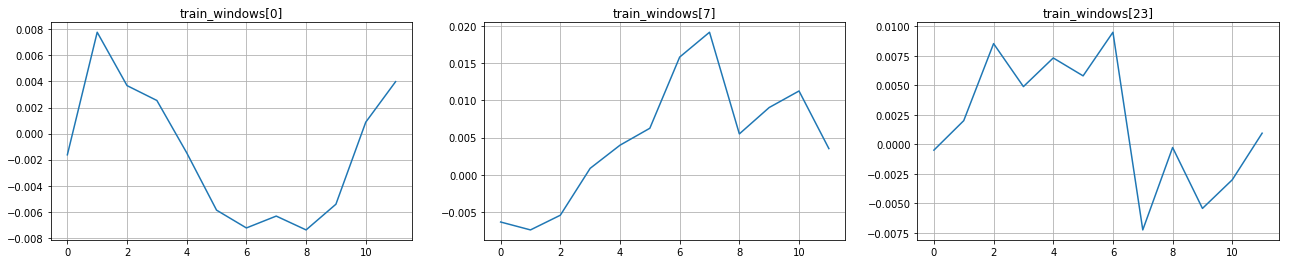

In [18]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

**Prepare Validation Sequences: Create windows of 48 data points each**

In [19]:
valid_windows = []

In [20]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [21]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [22]:
x_valid = np.array(valid_windows)
x_valid.shape

(709, 12, 1)

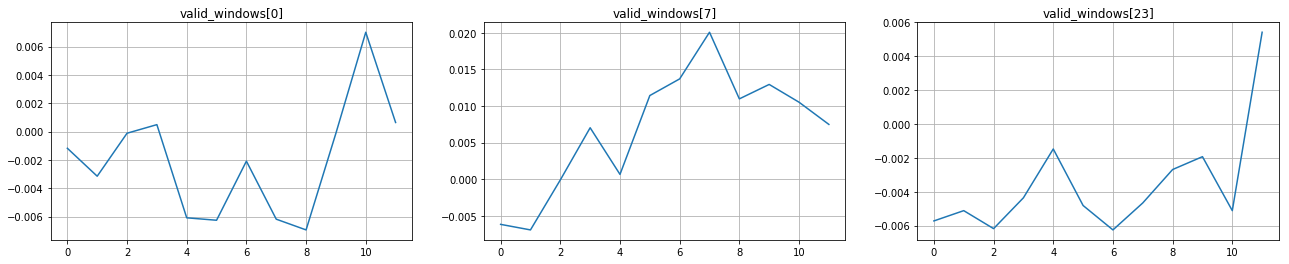

In [23]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

### Create the LSTM Auto-Encoder Model

In [24]:
input_length = window_length
input_dim = 1
hidden_dim = 12
batch_size = 48 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 50

In [25]:
def mode11():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='linear'))
    return m

In [26]:
def model2():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='sigmoid'))
    m.add(Activation('linear'))
    #m.add(Dense(1, activation='linear'))
    #try with Dense no activation
    #m.add(Dense(1))
    return m

In [27]:
def model3():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    #try with Dense no activation
    m.add(Dense(1))
    return m

In [28]:
def model4():
    m = Sequential()
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(GRU(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    #m.add(Dense(1, activation='linear'))
    m.add(Dense(1))
    return m

In [29]:
#m = model1()
#m = model2()
m = model3()
#m = model3()

In [30]:
m.compile(loss='mse', optimizer='adam')

In [31]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 24)            2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 24)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 12)            1776      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 12)            1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 24)            3552      
__________

In [32]:
checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
tbCallBack = TensorBoard(log_dir='./lstm.autoencoder.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

In [33]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid), callbacks=[checkpointer, earlystopper, tbCallBack]).history

Train on 2197 samples, validate on 709 samples
Epoch 1/50
2197/2197 [==============================] - ETA: 0s - loss: 1.0342e-04 - val_loss: 9.0369e-05
Epoch 2/50
2197/2197 [==============================] - ETA: 0s - loss: 1.0278e-04 - val_loss: 9.4746e-05
Epoch 3/50
2197/2197 [==============================] - ETA: 0s - loss: 1.0264e-04 - val_loss: 9.2084e-05
Epoch 4/50
2197/2197 [==============================] - ETA: 0s - loss: 1.0282e-04 - val_loss: 8.9739e-05
Epoch 5/50
2197/2197 [==============================] - ETA: 0s - loss: 1.0053e-04 - val_loss: 1.0109e-04
Epoch 6/50
2197/2197 [==============================] - ETA: 0s - loss: 9.1881e-05 - val_loss: 7.6521e-05
Epoch 7/50
2197/2197 [==============================] - ETA: 0s - loss: 8.6295e-05 - val_loss: 7.3907e-05
Epoch 8/50
2197/2197 [==============================] - ETA: 0s - loss: 8.2588e-05 - val_loss: 6.9586e-05
Epoch 9/50
2197/2197 [==============================] - ETA: 0s - loss: 8.2663e-05 - val_loss: 7.0386e-05

2197/2197 [==============================] - ETA: 0s - loss: 1.9742e-05 - val_loss: 6.2816e-06
Epoch 32/50
2197/2197 [==============================] - ETA: 0s - loss: 1.9786e-05 - val_loss: 6.4474e-06
Epoch 33/50
2197/2197 [==============================] - ETA: 0s - loss: 1.9526e-05 - val_loss: 7.6495e-06
Epoch 34/50
2197/2197 [==============================] - ETA: 0s - loss: 1.8947e-05 - val_loss: 6.5867e-06
Epoch 35/50
2197/2197 [==============================] - ETA: 0s - loss: 1.8744e-05 - val_loss: 6.2647e-06
Epoch 36/50
2197/2197 [==============================] - ETA: 0s - loss: 1.8439e-05 - val_loss: 5.6498e-06
Epoch 37/50
2197/2197 [==============================] - ETA: 0s - loss: 1.7886e-05 - val_loss: 6.0353e-06
Epoch 38/50
2197/2197 [==============================] - ETA: 0s - loss: 1.7916e-05 - val_loss: 5.3837e-06
Epoch 39/50
2197/2197 [==============================] - ETA: 0s - loss: 1.7761e-05 - val_loss: 5.2795e-06
Epoch 40/50
2197/2197 [==========================

In [34]:
#model_file = 'auto-encoder-anom.h5'
#m.save(model_file)

In [35]:
pred_x_valid = m.predict(x_valid)

### Visualize the reconstruction on the validation set (select random sets)

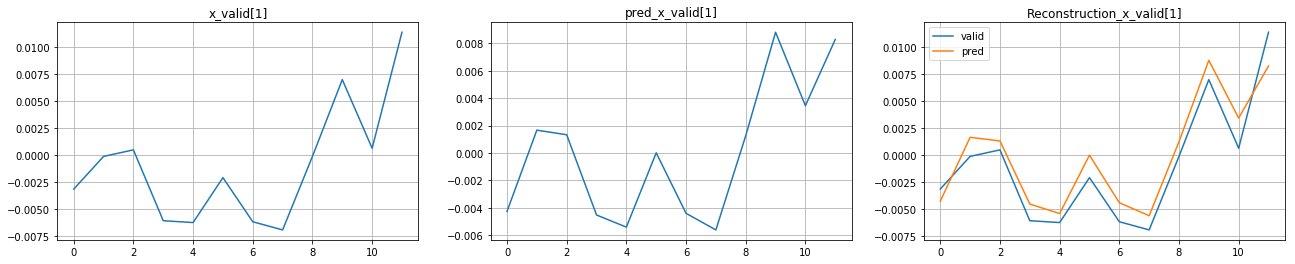

In [36]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[1])
plt.title('x_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[1])
plt.title('pred_x_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[1], label='valid')
plt.plot(pred_x_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[1]')
plt.grid(True)
plt.show();

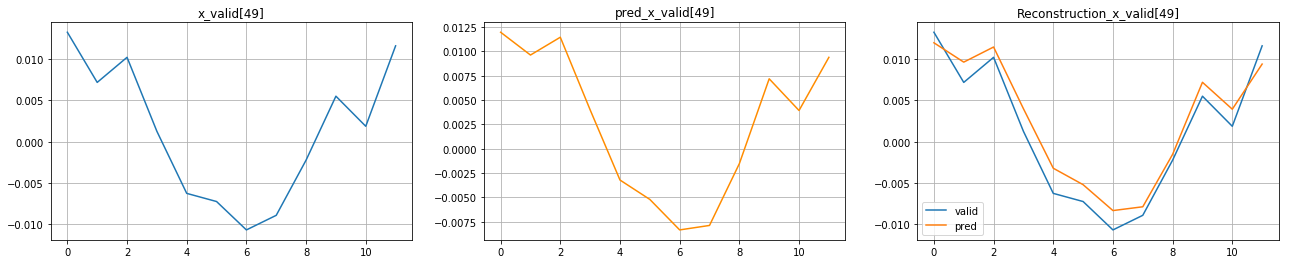

In [37]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[49])
plt.title('x_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[49], label='valid')
plt.plot(pred_x_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[49]')
plt.grid(True)
plt.show();

### Summarise Model Loss Over Training Epochs

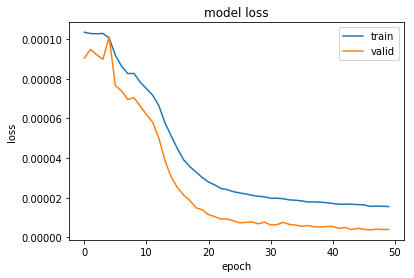

In [38]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [39]:
signal_test[201]

array([-0.01148523])

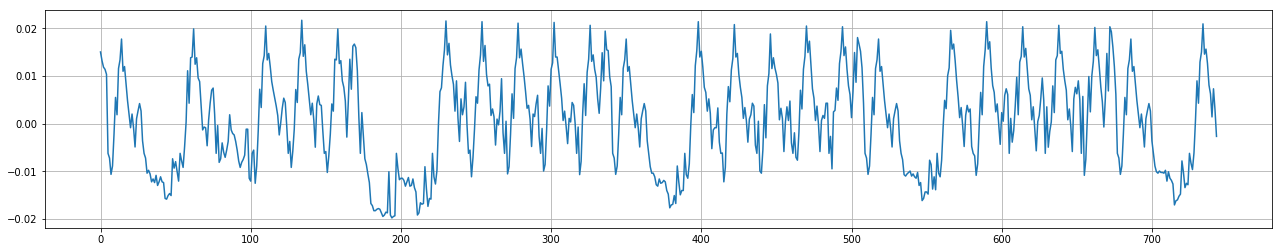

In [40]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.grid(True)

### Simulate Anomalies on the test set (select random points)

In [41]:
simulated_signal_test = np.copy(signal_test)

In [42]:
random_indices = [201, 422] # random points chosen
simulated_signal_test[random_indices]

array([[-0.01148523],
       [ 0.02081718]])

In [43]:
# switching over values to crete anomaly
simulated_signal_test[201] = 0.02081718 # 0.81
simulated_signal_test[422] = -0.01148523 # 0.35

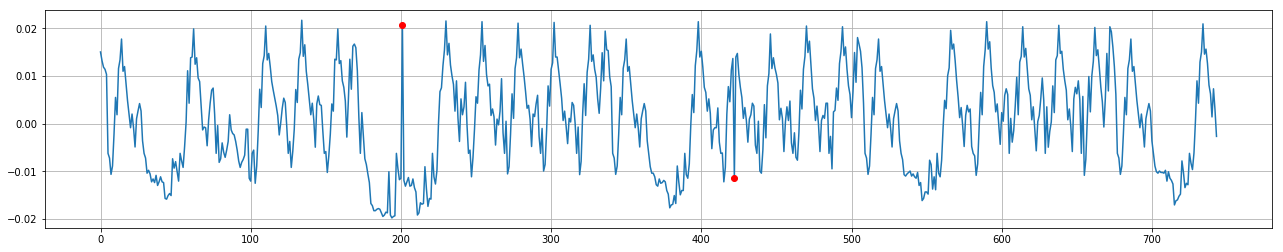

In [44]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
plt.grid(True)

**Prepare Test Sequences: Create windows of 48 data points each**

In [45]:
test_windows = []
contain_outliers= []

In [46]:
for window_start in range(0, len(simulated_signal_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(simulated_signal_test[window_range])
    is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    contain_outliers.append(is_outlier)
    test_windows.append(window)

In [47]:
x_test = np.array(test_windows)
x_test.shape

(733, 12, 1)

In [48]:
pred_x_test = m.predict(x_test)

### Visualize the reconstruction on the simulated test set (select random sets)

In [49]:
outlier_indices = np.where(contain_outliers)[0]

In [50]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422], dtype=int64)

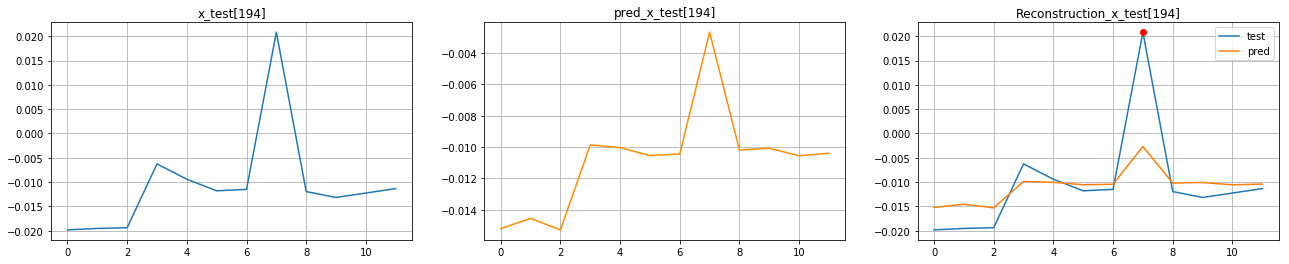

In [51]:
# Visualize the reconstruction on a random test sequence
left = random_indices[0]
choose = outlier_indices[4]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[choose])
plt.title('x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[choose], color='darkorange')
plt.title('pred_x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[choose], label='test')
plt.plot(pred_x_test[choose], label='pred')
plt.plot(left - choose, x_test[choose][left-choose], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[{0}]'.format(choose))
plt.grid(True)
plt.show();

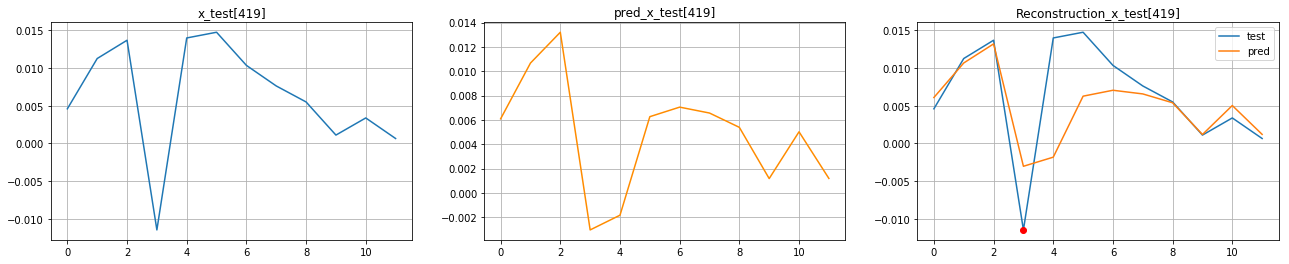

In [52]:
# Visualize the reconstruction on a random test sequence
left = random_indices[1]
choose = outlier_indices[-4]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[choose])
plt.title('x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[choose], color='darkorange')
plt.title('pred_x_test[{0}]'.format(choose))
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[choose], label='test')
plt.plot(pred_x_test[choose], label='pred')
plt.plot(left - choose, x_test[choose][left-choose], marker='o', color='red')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[{0}]'.format(choose))
plt.grid(True)
plt.show();

### Find the distribution of Reconstruction Errors on Validation and Test Set

Take the difference between the predicted values in each window with the actual value for the corresponding window in the validation set.

For each window we skip the first point in that window because the network always gives bad recontruction for the first point. 

Collect all the values and plot a distribution of the errors

In [53]:
all_errors_valid = pd.Series(np.squeeze(x_valid[:,1:,:] - pred_x_valid[:,1:,:]).flatten())
all_errors_test = pd.Series(np.squeeze(x_test[:,1:,:] - pred_x_test[:,1:,:]).flatten())

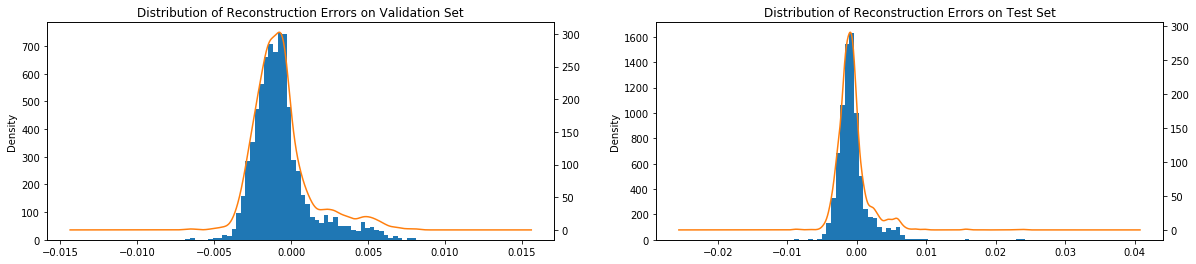

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
all_errors_valid.plot.hist(bins=50, ax=ax[0])
all_errors_valid.plot.kde(secondary_y=True, ax=ax[0])
ax[0].set_title('Distribution of Reconstruction Errors on Validation Set')
all_errors_test.plot.hist(bins=50, ax=ax[1])
all_errors_test.plot.kde(secondary_y=True, ax=ax[1])
ax[1].set_title('Distribution of Reconstruction Errors on Test Set');

### Approach 1: Rank all Test windows by comparing the probability of getting such Reconstruction Errors with those in the validation set

**Fit a Kernel Density Estimation Function on the validation errors**

In [55]:
from scipy import stats
kernel_errors = stats.gaussian_kde(all_errors_valid.values)

**Investigate the Reconstruction Errors in the Test Set**

In [56]:
errors_test_per_window = np.squeeze(x_test[:,1:,:] - pred_x_test[:,1:,:])
errors_test_per_window

array([[ -1.49809843e-03,  -2.41888946e-03,  -1.94546424e-03, ...,
         -8.43859484e-04,  -1.57290624e-03,  -1.95831265e-03],
       [ -2.31915506e-03,  -2.48827536e-03,  -2.25470338e-03, ...,
         -1.56661423e-03,  -1.95362484e-03,   2.35252823e-03],
       [ -2.43394945e-03,  -2.81789090e-03,  -6.82471573e-03, ...,
         -1.94695494e-03,   2.34556287e-03,   3.85699482e-04],
       ..., 
       [ -1.89174632e-03,   3.07815284e-03,   2.36426169e-03, ...,
         -4.93580844e-05,  -8.45819470e-04,   1.19682509e-03],
       [  2.35981349e-03,   1.74045345e-03,   6.02392346e-03, ...,
         -8.60438440e-04,   1.18968464e-03,  -3.45086194e-04],
       [  3.74411848e-04,   5.29002357e-03,  -6.81514015e-04, ...,
          1.19892616e-03,  -3.41686867e-04,  -1.10574976e-03]])

In [57]:
# reconstruction errors in test set in window 0
errors_test_per_window[0]

array([-0.0014981 , -0.00241889, -0.00194546, -0.00173566, -0.00648542,
       -0.00427728, -0.00363122, -0.00193343, -0.00084386, -0.00157291,
       -0.00195831])

In [58]:
# calculate the sum of probability of getting the reconstruction errors for window[0]
sum_errors_pdf_window_0 = np.sum([kernel_errors.integrate_box(error - 1e-8, error + 1e-8) for error in errors_test_per_window[0]])
sum_errors_pdf_window_0

4.0745329285885462e-05

**calculate the sum of probability of getting those errors in each window**

Apply integration to get the areas under the curve of the pdf for each error in each window and sum them up. If the reconstruction error is high, then the area under the pdf curve for that error will be low because the chance of getting that reonstruction error in normal/validation sequences in low. Sum the areas under the pdf curve for each error in a window to get a sense of measure of the degree of reconstruction error for that window.

In [59]:
def sum_errors_pdf_window(errors_in_window):
    return np.sum([kernel_errors.integrate_box(error - 1e-8, error + 1e-8) for error in errors_in_window])

In [60]:
sum_errors_pdf_per_window = pd.Series([sum_errors_pdf_window(errors_in_window) for errors_in_window in errors_test_per_window])

In [61]:
# check with our calculation for this window above
sum_errors_pdf_per_window[0]

4.0745329285885462e-05

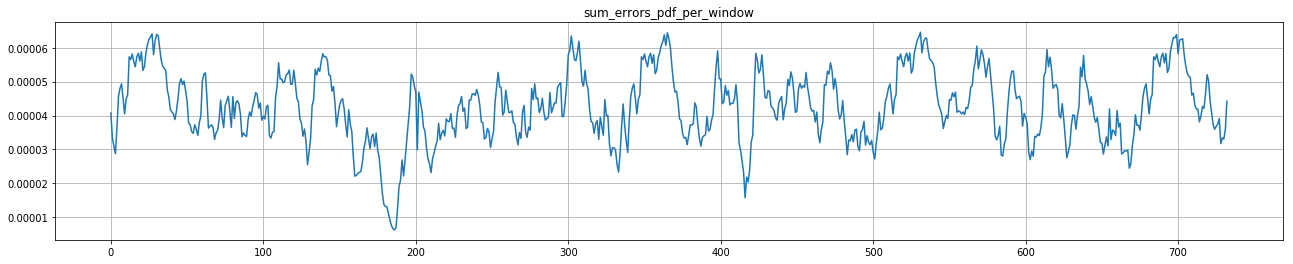

In [62]:
plt.figure(figsize=(22, 4))
plt.plot(sum_errors_pdf_per_window)
plt.title('sum_errors_pdf_per_window')
plt.grid(True, which='both');

**sort the windows by the lowest area under the pdf curve**

The lower the area under the curve, the less likely is to get those erros and hence hence more likely the window is a anomalous window

In [63]:
# Top anomalous windows ranked by area under pdf in ascending order
# we introduced anomalies in test windows 201 & 422
sum_errors_pdf_per_window.nsmallest(24)

186    0.000006
185    0.000007
187    0.000007
184    0.000008
183    0.000009
182    0.000011
188    0.000012
181    0.000013
180    0.000013
179    0.000014
416    0.000016
178    0.000017
189    0.000019
418    0.000020
190    0.000021
417    0.000022
160    0.000022
192    0.000022
161    0.000022
177    0.000022
162    0.000023
210    0.000023
163    0.000023
415    0.000023
dtype: float64

**Visualize the anomalous windows**

In [65]:
pred_outlier_indices = sum_errors_pdf_per_window.nsmallest(48).index.values
pred_outlier_indices

array([186, 185, 187, 184, 183, 182, 188, 181, 180, 179, 416, 178, 189,
       418, 190, 417, 160, 192, 161, 177, 162, 210, 163, 415, 333, 164,
       419, 668, 129, 332, 669, 209, 165, 414, 191, 603, 193, 501, 208,
       211, 627, 176, 605, 159, 585, 328, 584, 483], dtype=int64)

In [66]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422], dtype=int64)

In [67]:
print(set(outlier_indices).intersection(set(pred_outlier_indices)))

{416, 417, 418, 419, 191, 192, 193, 190, 414, 415}


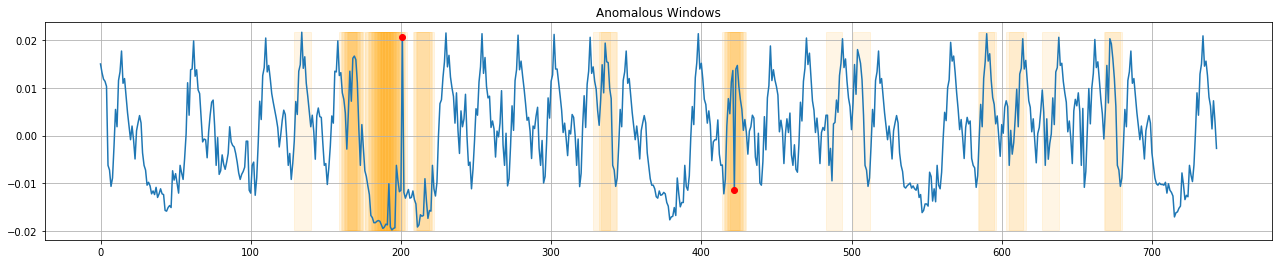

In [68]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
for w_index in pred_outlier_indices:
    plt.fill_betweenx((simulated_signal_test.min(), simulated_signal_test.max()), 
                      w_index, w_index + window_length - 1, alpha=0.1, color='orange')
plt.title('Anomalous Windows')
plt.grid(True);

**Metrics**

In [69]:
tp = len(set(outlier_indices).intersection(set(pred_outlier_indices)))

In [70]:
fn = len(set(outlier_indices) - set(pred_outlier_indices))

In [71]:
fp = len(set(pred_outlier_indices) - set(outlier_indices))

In [72]:
all_indices = set(range(len(x_test))) 
tn = len((all_indices - set(outlier_indices)).intersection(all_indices - set(pred_outlier_indices)))

In [73]:
precision = float(tp) / (tp + fp)

In [74]:
hit_rate = float(tp) / (tp + fn)

In [75]:
accuracy = float(tp + tn) / (tp + tn + fp + fn)

In [76]:
print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 0.20833333333333334, hit_rate = 0.4166666666666667, accuracy = 0.9290586630286494


### Approach 2: Rank all Test windows by the sum of their absolute values of the  Reconstruction Errors

In [77]:
errors_test_per_window = np.squeeze(x_test[:,1:,:] - pred_x_test[:,1:,:])
errors_test_per_window

array([[ -1.49809843e-03,  -2.41888946e-03,  -1.94546424e-03, ...,
         -8.43859484e-04,  -1.57290624e-03,  -1.95831265e-03],
       [ -2.31915506e-03,  -2.48827536e-03,  -2.25470338e-03, ...,
         -1.56661423e-03,  -1.95362484e-03,   2.35252823e-03],
       [ -2.43394945e-03,  -2.81789090e-03,  -6.82471573e-03, ...,
         -1.94695494e-03,   2.34556287e-03,   3.85699482e-04],
       ..., 
       [ -1.89174632e-03,   3.07815284e-03,   2.36426169e-03, ...,
         -4.93580844e-05,  -8.45819470e-04,   1.19682509e-03],
       [  2.35981349e-03,   1.74045345e-03,   6.02392346e-03, ...,
         -8.60438440e-04,   1.18968464e-03,  -3.45086194e-04],
       [  3.74411848e-04,   5.29002357e-03,  -6.81514015e-04, ...,
          1.19892616e-03,  -3.41686867e-04,  -1.10574976e-03]])

In [78]:
# reconstruction errors in test set in window 0
errors_test_per_window[0]

array([-0.0014981 , -0.00241889, -0.00194546, -0.00173566, -0.00648542,
       -0.00427728, -0.00363122, -0.00193343, -0.00084386, -0.00157291,
       -0.00195831])

In [79]:
# calculate the sum of absolute reconstruction errors for window[0]
sum_abs_errors_window_0 = np.sum(np.abs(errors_test_per_window[0]))
sum_abs_errors_window_0

0.028300534090940875

**calculate the sum of absolute values of recontruction errors in each window**

If the reconstruction error is high then the chances of that window being anomalous is high, because if the netwrok has learned well reonstructing the normal or non-anomalous subsequences/window then the reonstruction errors in those winodws will be low.

In [80]:
def sum_abs_errors_window(errors_in_window):
    return np.sum(np.abs(errors_in_window))

In [81]:
sum_abs_errors_per_window = pd.Series([sum_abs_errors_window(errors_in_window) for errors_in_window in errors_test_per_window])

In [82]:
# check with our calculation for this window above
sum_abs_errors_per_window[0]

0.028300534090940875

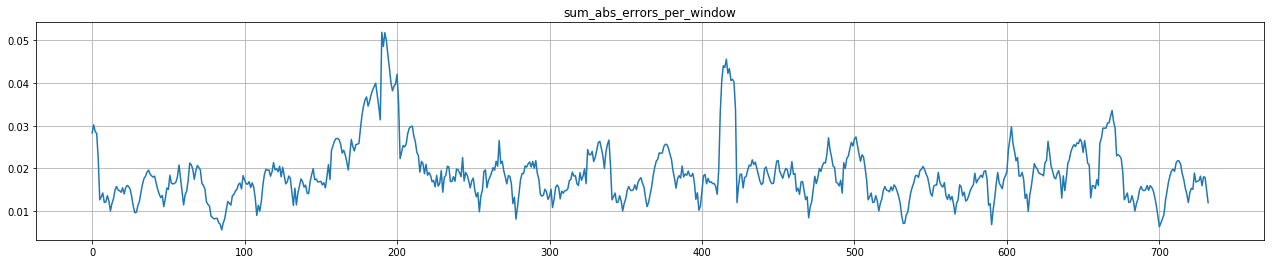

In [83]:
plt.figure(figsize=(22, 4))
plt.plot(sum_abs_errors_per_window)
plt.title('sum_abs_errors_per_window')
plt.grid(True, which='both');

**sort the windows by the highest absolute value of reconstruction errors**

The higher the sum of the reconstruction errors the more likely the window is a anomalous window because the sum of reconstruction errors for non-anomalous windows should be low

In [84]:
# Top anomalous windows ranked sum of the reconstruction errors in descending order
# we introduced anomalies in test windows 201 & 422
sum_abs_errors_per_window.nlargest(24)

190    0.051876
192    0.051768
193    0.049923
191    0.048523
194    0.046553
416    0.045574
414    0.044029
415    0.043646
195    0.043452
418    0.043379
417    0.042262
200    0.042028
420    0.040861
413    0.040616
419    0.040572
421    0.040285
196    0.040118
186    0.039951
199    0.039750
198    0.039216
185    0.039197
184    0.038368
197    0.038167
183    0.037272
dtype: float64

In [85]:
pred_outlier_indices = sum_abs_errors_per_window.nlargest(48).index.values
pred_outlier_indices

array([190, 192, 193, 191, 194, 416, 414, 415, 195, 418, 417, 200, 420,
       413, 419, 421, 196, 186, 199, 198, 185, 184, 197, 183, 187, 180,
       179, 182, 201, 181, 178, 188, 422, 669, 412, 177, 668, 189, 670,
       667, 666,   1, 210, 209, 603, 663, 665, 664], dtype=int64)

In [86]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422], dtype=int64)

In [87]:
print(set(outlier_indices).intersection(set(pred_outlier_indices)))

{412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201}


**Visualize the anomalous windows**

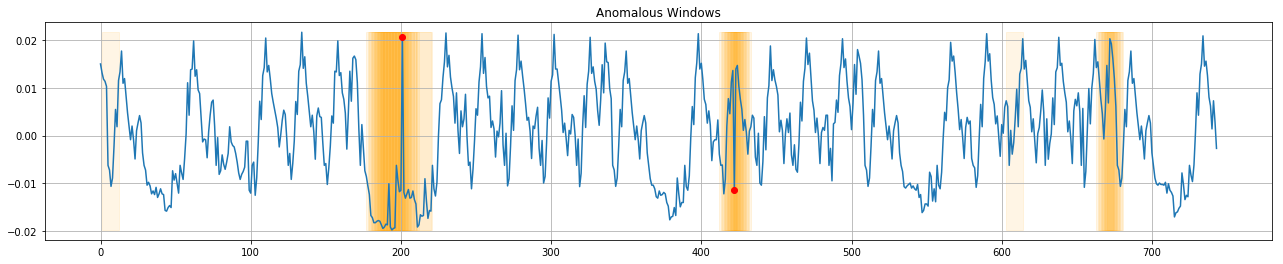

In [88]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
for w_index in pred_outlier_indices:
    plt.fill_betweenx((simulated_signal_test.min(), simulated_signal_test.max()), 
                      w_index, w_index + window_length - 1, alpha=0.1, color='orange')
plt.title('Anomalous Windows')
plt.grid(True);

**Metrics**

In [89]:
tp = len(set(outlier_indices).intersection(set(pred_outlier_indices)))

In [90]:
fn = len(set(outlier_indices) - set(pred_outlier_indices))

In [91]:
fp = len(set(pred_outlier_indices) - set(outlier_indices))

In [92]:
all_indices = set(range(len(x_test))) 
tn = len((all_indices - set(outlier_indices)).intersection(all_indices - set(pred_outlier_indices)))

In [93]:
precision = float(tp) / (tp + fp)

In [94]:
hit_rate = float(tp) / (tp + fn)

In [95]:
accuracy = float(tp + tn) / (tp + tn + fp + fn)

In [96]:
print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 0.4791666666666667, hit_rate = 0.9583333333333334, accuracy = 0.9645293315143247


### Approach 3: Create a threshold from the distribution of the Reconstruction Errors and Select Test windows that fall outside that threshold range to be marked as anomalous

In [97]:
max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
#max_mae_of_predictions

In [98]:
avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
#avg_mae_of_predictions

In [99]:
df = pd.DataFrame(data=np.c_[max_mae_of_predictions, avg_mae_of_predictions], 
                  columns=['max_mae_of_predictions', 'avg_mae_of_predictions'])
df.sample(3)

,max_mae_of_predictions,avg_mae_of_predictions
136,0.000009,0.000003
337,0.000026,0.000006
486,0.000027,0.000006


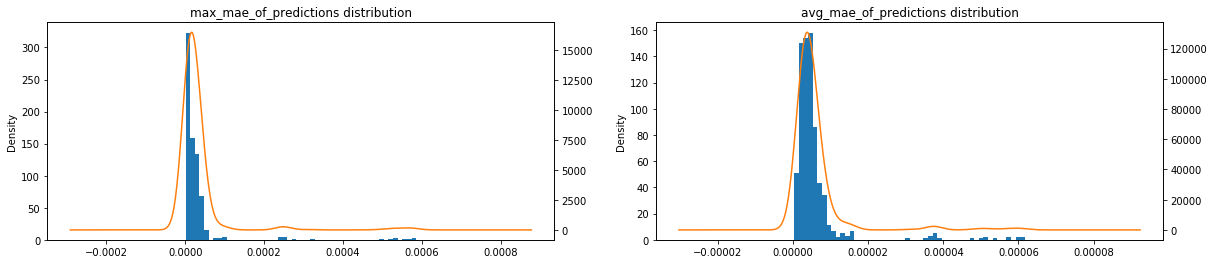

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
df['max_mae_of_predictions'].plot.hist(bins=50, ax=ax[0])
df['max_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[0])
ax[0].set_title('max_mae_of_predictions distribution')
df['avg_mae_of_predictions'].plot.hist(bins=50, ax=ax[1])
df['avg_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[1])
ax[1].set_title('avg_mae_of_predictions distribution');

In [101]:
from scipy import stats
kernel_max_mae = stats.gaussian_kde(df['max_mae_of_predictions'].values)
kernel_avg_mae = stats.gaussian_kde(df['avg_mae_of_predictions'].values)

In [102]:
df['pdf_max_mae'] = df['max_mae_of_predictions'].map(lambda x: kernel_max_mae.integrate_box(x - 1e-8, x + 1e-8))
df['pdf_avg_mae'] = df['avg_mae_of_predictions'].map(lambda x: kernel_avg_mae.integrate_box(x - 1e-8, x + 1e-8))

In [103]:
# Top anomalous points by max_mae
df.nlargest(10, columns=['pdf_max_mae'])

,max_mae_of_predictions,avg_mae_of_predictions,pdf_max_mae,pdf_avg_mae
642,0.000016,0.000006,0.00033,0.002028
504,0.000016,0.000005,0.00033,0.002425
622,0.000016,0.000004,0.00033,0.002562
180,0.000016,0.000011,0.00033,0.000219
379,0.000016,0.000005,0.00033,0.002211
259,0.000016,0.000004,0.00033,0.002607
260,0.000016,0.000004,0.00033,0.002573
258,0.000016,0.000005,0.00033,0.002408
621,0.000016,0.000004,0.00033,0.002577
257,0.000016,0.000005,0.00033,0.002392


In [104]:
# Top anomalous points by avg_mae
df.nlargest(10, columns=['pdf_avg_mae'])

,max_mae_of_predictions,avg_mae_of_predictions,pdf_max_mae,pdf_avg_mae
543,0.000010,0.000004,0.000316,0.002617
448,0.000008,0.000004,0.000310,0.002617
462,0.000028,0.000004,0.000294,0.002617
710,0.000012,0.000004,0.000325,0.002617
241,0.000008,0.000004,0.000306,0.002617
595,0.000022,0.000004,0.000319,0.002617
476,0.000014,0.000004,0.000329,0.002617
113,0.000013,0.000004,0.000325,0.002617
451,0.000010,0.000004,0.000318,0.002617
547,0.000012,0.000004,0.000324,0.002617


In [105]:
max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)  # can use a running mean instead.
max_mae_threshold

0.00010287178636763069

In [106]:
pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
pred_outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422], dtype=int64)

In [107]:
len(pred_outlier_indices)

22

In [108]:
outlier_indices

array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422], dtype=int64)

In [109]:
len(outlier_indices)

24

In [110]:
print(set(outlier_indices).intersection(set(pred_outlier_indices)))

{412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}


**Visualize the anomalous windows**

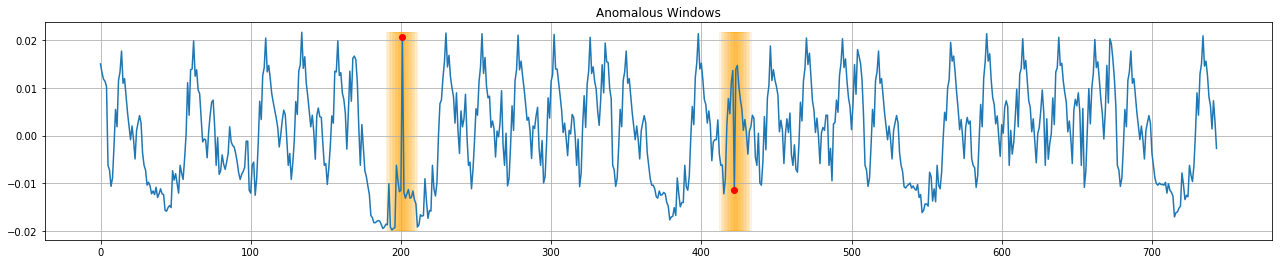

In [111]:
plt.figure(figsize=(22, 4))
plt.plot(simulated_signal_test)
plt.plot(201, simulated_signal_test[201], marker='o', color='red')
plt.plot(422, simulated_signal_test[422], marker='o', color='red')
for w_index in pred_outlier_indices:
    plt.fill_betweenx((simulated_signal_test.min(), simulated_signal_test.max()), 
                      w_index, w_index + window_length - 1, alpha=0.1, color='orange')
plt.title('Anomalous Windows')
plt.grid(True);

**Metrics**

In [112]:
tp = len(set(outlier_indices).intersection(set(pred_outlier_indices)))

In [113]:
fn = len(set(outlier_indices) - set(pred_outlier_indices))

In [114]:
fp = len(set(pred_outlier_indices) - set(outlier_indices))

In [115]:
all_indices = set(range(len(x_test))) 
tn = len((all_indices - set(outlier_indices)).intersection(all_indices - set(pred_outlier_indices)))

In [116]:
precision = float(tp) / (tp + fp)

In [117]:
hit_rate = float(tp) / (tp + fn)

In [118]:
accuracy = float(tp + tn) / (tp + tn + fp + fn)

In [119]:
print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 0.9166666666666666, accuracy = 0.9972714870395635
